[nltk_data] Downloading package stopwords to
[nltk_data]     /home/golopes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/100
6/6 - 14s - loss: 56.8655 - accuracy: 0.8987 - val_loss: 24.1634 - val_accuracy: 0.8943 - 14s/epoch - 2s/step
Epoch 2/100
6/6 - 22s - loss: 17.9107 - accuracy: 0.8035 - val_loss: 2.1000 - val_accuracy: 0.1200 - 22s/epoch - 4s/step
Epoch 3/100
6/6 - 12s - loss: -1.0868e+02 - accuracy: 0.0707 - val_loss: -1.8199e+02 - val_accuracy: 0.0248 - 12s/epoch - 2s/step
Epoch 4/100
6/6 - 12s - loss: -2.0364e+02 - accuracy: 0.0152 - val_loss: -1.8145e+02 - val_accuracy: 0.0248 - 12s/epoch - 2s/step
Epoch 5/100
6/6 - 10s - loss: -2.0342e+02 - accuracy: 0.0152 - val_loss: -1.8145e+02 - val_accuracy: 0.0248 - 10s/epoch - 2s/step
Epoch 6/100
6/6 - 11s - loss: -2.0342e+02 - accuracy: 0.0152 - val_loss: -1.8145e+02 - val_accuracy: 0.0248 - 11s/epoch - 2s/step
Epoch 7/100
6/6 - 13s - loss: -2.0342e+02 - accuracy: 0.0152 - val_loss: -1.8145e+02 - val_accuracy: 0.0248 - 13s/epoch - 2s/step
Epoch 8/100
6/6 - 11s - loss: -2.0342e+02 - accuracy: 0.0152 - val_loss: -1.8145e+02 - val_accuracy: 0.0248

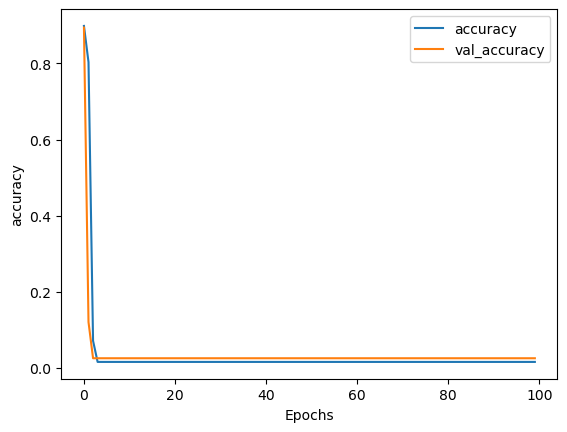

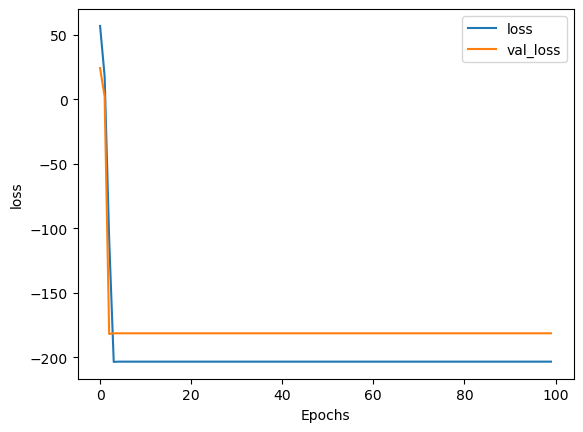

In [38]:
import tensorflow as tf
from tensorflow import keras
import csv
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords') # install NLTK data to home user directory
from nltk.corpus import stopwords
import unidecode
import random
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@;]')
BAD_SYMBOLS_RE = re.compile('[^a-z 0-9 #+_]')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS_RE = re.compile(r"\b(" + "|".join(STOPWORDS) + ")\\W")

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    #text = # lowercase text
    text = unidecode.unidecode(text).lower()
    #text = # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(" ", text)
    #text = # delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub(" ", text)
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)

    #text = # delete stopwords from text
    text = STOPWORDS_RE.sub("", text)

    return text

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
def prepare_seq(sequence,max):
    sequence = tokenizer.texts_to_sequences(sequence)
    sequence = pad_sequences(sequence, maxlen=max, padding=padding_type, truncating=trunc_type)
    return  np.array(sequence)

# rows = []
# dataset = []
# with open('../new_recipes.csv') as file:
#     csvreader = csv.reader(file)
#     header = next(csvreader)
#     for row in csvreader:
#         rows.append(row)

# random.shuffle(rows)

training_size =60
vocab_size = 1000
embedding_dim = 32
num_epochs = 100
batch_size = 10

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
# labels=[]
# sentences=[]
max_length_sentence=100
max_length_label=100

# for row in rows:
#     recipes=row[4]
#     label=' '.join(row[:2])
#     sentences.append(text_prepare(recipes))
#     labels.append(label)
data = pd.read_csv('../new_recipes.csv')
sentences=data["recipe"]
labels=data["ingredients"]

# print("chegou")
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]
    
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences=prepare_seq(training_sentences,max_length_sentence)
testing_sequences = prepare_seq(testing_sentences,max_length_sentence)
training_lab_padded = prepare_seq(training_labels,max_length_label)
testing_lab_padded = prepare_seq(testing_labels,max_length_label)
# print(testing_sequences)
# print(testing_lab_padded)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length_sentence),
    # tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # tf.keras.layers.Dense(max_length_label)
    # tf.keras.layers.Dense(24, activation='sigmoid')
    # tf.keras.layers.Embedding(input_dim=vocab_size, mask_zero=True, output_dim=50),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

# tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')

# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.compile(
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#     optimizer="adam",
#     metrics=["accuracy"],
# )

model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(training_sequences, training_lab_padded, batch_size=batch_size, epochs=num_epochs, validation_data=(testing_sequences, testing_lab_padded), verbose=2)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [40]:

input_txt = open("../test.txt", "r")
input_padded=prepare_seq(input_txt,max_length_sentence)
input_padded = np.squeeze(input_padded)

result = model.predict_on_batch(tf.expand_dims(input_padded,0))

# result =result*(result > 0.05)
# print(result)
# result=result*vocab_size
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

result_final=[]
for a in np.squeeze(result):
    for i in reverse_word_index:
        if(int(a)==i):
            if(reverse_word_index[i] not in result_final):
                result_final.append(reverse_word_index[i])
            break

print(','.join(result_final))

mix,a,for,add,minutes,to,in,and,<OOV>
